In [1]:
import numpy as np
from itertools import combinations
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity
from qclib.state_preparation import MixedInitialize
from qclib.machine_learning.datasets import digits
from qclib.entanglement import schmidt_decomposition
from qclib.state_preparation.util.baa import _split_combinations
from qclib.util import get_cnot_count

# If you are not using the `qdna-lib` source code,
# comment out the following two lines.
import sys
sys.path.append('../../qdna-lib/')

from qdna.compression import SchmidtCompressor

In [2]:
# Dataset load.
seed = 42

# Here you can choose the dataset classes. For example: [3], [0,1], [1,8], [2,4,7], etc.
sample_total, training_input, test_input, class_labels = digits.load(classes=[7],
                                                                     training_size=160,
                                                                     test_size=20,
                                                                     random_seed=seed)
feature_dim = len(training_input[class_labels[0]][0])
n_qubits = int(np.ceil(np.log2(feature_dim)))

# Variables to collect data for the summary.
fidelities = [[],[],[]]
figures = [[],[],[]]

In [3]:
# Prints information on training and test datasets.
for _, train_samples in training_input.items():
    print(train_samples.shape)
for _, test_samples in test_input.items():
    print(test_samples.shape)

(159, 64)
(20, 64)


In [4]:
# Utility functions.
# def calc_fidelity(state1, state2):
#     bra = np.conj(state1)
#     ket = state2

#     return np.power(np.abs(bra.dot(ket)), 2)

def plot_digits(vectors, num_data_qubits, text=''):
    import matplotlib.pyplot as plt
    _dpi = 96
    matrix_dim_1 = 2**(int(np.ceil(num_data_qubits/2)))
    matrix_dim_2 = 2**(int(np.floor(num_data_qubits/2)))

    ncols = len(vectors)
    _, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*10*matrix_dim_1/_dpi, 10*matrix_dim_2/_dpi), dpi=_dpi)
    for ax, vector in zip(axes, vectors):
        ax.set_axis_off()
        image = vector.reshape(matrix_dim_1, matrix_dim_2)
        ax.imshow(image, cmap=plt.cm.gray, interpolation='none')

    plt.show()

***
## Experiment main routine
***

In [5]:
def experiment(test_input, compressor, decompressor, references=None, verbose=1):
    # Applies the compression-decompression process to each of the test samples.

    fidelities = []
    figures = []

    # Info about the auxiliary space.
    aux_zero = [1]
    n_aux_qubits = 0
    if references is not None:
        len_aux = references[0][0].num_qubits // 2
        n_aux_qubits = len_aux * len(references[0])
        aux_zero = [1] + [0] * (2**n_aux_qubits-1)
        aux_qubits = np.array(range(n_qubits, n_qubits+n_aux_qubits))

    # Iterates through all test samples.
    for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
        initializer = StatePreparation(test_sample)

        # Circuit on Alice's side.
        circuit = QuantumCircuit(n_qubits + n_aux_qubits)
        circuit.append(initializer.definition, range(n_qubits))
        circuit.append(compressor.definition, range(n_qubits))
        circuit.reset(compressor.trash_qubits)

        # Circuit on Bob's side.
        if references is not None:
            trash_qubits = np.array(compressor.trash_qubits)
            for j, ref_initializer in enumerate(references[i]):
                qubits_idx = list(range(j * len_aux, (j+1) * len_aux))
                circuit.compose(
                    ref_initializer.definition,
                    [*aux_qubits[qubits_idx], *trash_qubits[qubits_idx]],
                    inplace=True
                )
        circuit.append(decompressor.definition, range(n_qubits))

        # Compares the recovered state with the original state.
        #
        # There is a sporadic bug in the reset.
        # For now, I've decided to run the same piece of code five
        # times to avoid it, but at some point it will be necessary
        # to investigate the problem.
        output_probs = None
        fidelity = 0.0
        _input_state = DensityMatrix(test_sample, dims=2**n_qubits)
        input_probs = _input_state.probabilities()
        #for _ in range(10):
        _output_state = partial_trace(DensityMatrix(circuit), range(n_qubits, circuit.num_qubits))
        _fidelity = state_fidelity(_input_state, _output_state)
        if _fidelity > fidelity:
            fidelity = _fidelity
            output_probs = _output_state.probabilities()

        # Stores and prints the results.
        fidelities.append(fidelity)
        figures.append([input_probs, output_probs])
        if verbose > 0:
            print(i, '- Recovered state fidelity =', fidelity)
        if verbose > 1:
            plot_digits([input_probs, output_probs], n_qubits)

    return fidelities, figures

In [6]:
# Creates an example of the circuit.
def complete_circuit(compressor, decompressor, references=None):

    # Random typical state.
    typical_state = np.random.rand(2**n_qubits)
    typical_state = typical_state / np.linalg.norm(typical_state)

    # Typical state initializer.
    initializer = StatePreparation(typical_state)

    # Info about the auxiliary space.
    n_aux_qubits = 0
    if references is not None:
        len_aux = references[0][0].num_qubits // 2
        n_aux_qubits = len_aux * len(references[0])
        aux_qubits = np.array(range(n_qubits, n_qubits + n_aux_qubits))

    # Creates the quantum circuit.
    circuit = QuantumCircuit(n_qubits + n_aux_qubits)

    # Circuit on Alice's side.
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))
    circuit.reset(compressor.trash_qubits)

    # Circuit on Bob's side.
    if references is not None:
        circuit.barrier()
        trash_qubits = np.array(compressor.trash_qubits)
        for i, ref_initializer in enumerate(references[0]):
            qubits_idx = list(range(i * len_aux, (i+1) * len_aux))
            circuit.compose(
                ref_initializer.definition,
                [*aux_qubits[qubits_idx], *trash_qubits[qubits_idx]],
                inplace=True
            )
        circuit.barrier()
    circuit.append(decompressor.definition, range(n_qubits))

    return circuit    

***
## Calculates the typical state
***

In [7]:
# Estimate the centroid.
# Simply the average of the training samples (or a random selection of samples).

centroid = np.zeros(2**n_qubits)
for train_sample in np.concatenate([train_samples for _, train_samples in training_input.items()]):
    centroid += train_sample

typical_state = centroid / np.linalg.norm(centroid)

print(typical_state.shape)

(64,)


In [8]:
np.linalg.norm(typical_state)

1.0

***
## Find the best partitioning configuration.
***

In [9]:
from scipy.linalg import logm
# Defines the number of latent qubits.
# `0 < n_latent_qubits < n_qubits`.
n_latent_partition = n_qubits // 2

n_trash_partition = n_qubits - n_latent_partition

def von_neumann_entropy(singular_values):
    squared_singular_values = np.power([s for s in singular_values if s >= 1e-17], 2)
    return -np.sum(squared_singular_values * np.log(squared_singular_values))

# Set `min_entropy` equal to the maximum entropy for the system.
min_entropy = von_neumann_entropy(
    [1/np.sqrt(2**n_trash_partition)] * 2**n_trash_partition
)

for partition in _split_combinations(range(n_qubits), n_trash_partition):
    rank, svd_u, singular_values, svd_v = schmidt_decomposition(
        typical_state, partition, rank=0, svd='auto'
    )

    # Entropy of entanglement.
    entropy = von_neumann_entropy(singular_values)

    # Calculates the von Neumann entropy of each reduced state, for comparison.
    set_a = set([n_qubits-i-1 for i in partition]) # Qiskit reverse.
    set_b = set(range(n_qubits)).difference(set_a)
    rho_a = partial_trace(typical_state, list(set_b))
    rho_b = partial_trace(typical_state, list(set_a))
    s_a = -np.trace(rho_a @ logm(rho_a)).real
    s_b = -np.trace(rho_b @ logm(rho_b)).real

    print('partition', partition, 'entropy', entropy, 's_a', s_a, 's_b', s_b)
    if entropy <= min_entropy:
        min_entropy = entropy
        trash_partition = partition
        latent_partition = sorted(set(range(n_qubits)).difference(set(trash_partition)))

partition (0, 1, 2) entropy 0.38802963204756347 s_a 0.3880296320475679 s_b 0.3880296320475637
partition (0, 1, 3) entropy 0.9077962222472205 s_a 0.9077962222472205 s_b 0.9077962222472205
partition (0, 1, 4) entropy 0.9205866246417678 s_a 0.9205866246417674 s_b 0.9205866246417673
partition (0, 1, 5) entropy 0.5757554942444947 s_a 0.5757554942444953 s_b 0.575755494244495
partition (0, 2, 3) entropy 0.9853481142070936 s_a 0.9853481142070932 s_b 0.9853481142070943
partition (0, 2, 4) entropy 0.9857139841630094 s_a 0.9857139841630093 s_b 0.9857139841630088
partition (0, 2, 5) entropy 0.5691882319674293 s_a 0.5691882319674282 s_b 0.5691882319674278
partition (0, 3, 4) entropy 0.5169973915773368 s_a 0.516997391577336 s_b 0.516997391577337
partition (0, 3, 5) entropy 0.9580106502150388 s_a 0.9580106502150382 s_b 0.9580106502150402
partition (0, 4, 5) entropy 0.9695458093994802 s_a 0.9695458093994804 s_b 0.9695458093994799


/home/israel/anaconda3/envs/py311/lib/python3.11/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


In [10]:
print('Best channel:', latent_partition)

Best channel: [3, 4, 5]


***
## Creates the compressor and the decompressor
***

In [11]:
# Creates the compressor.

# These are the qubits of the quantum channel for data transmission.
# It can take on any configuration. For example: [0], [0,1,2,3,4], [1,3,5], etc.
latent_partition = [0,1,2]
trash_partition = [3,4,5]

compressor = SchmidtCompressor(typical_state, opt_params={'partition': trash_partition, 'lr': 0})
decompressor = compressor.inverse()

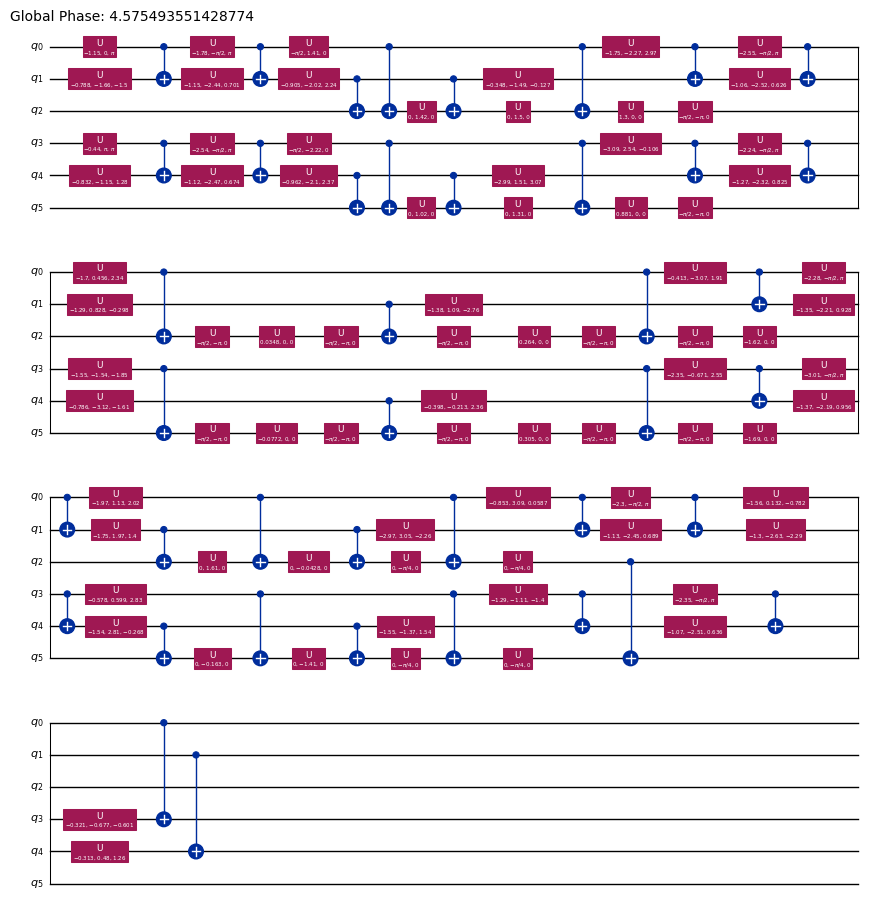

In [12]:
compressor.definition.decompose().draw('mpl', scale=0.5, style="iqp")

In [13]:
print(get_cnot_count(compressor.definition.decompose()))

41


***
## Experiment without optimization
***
Using |0> as the reference state.


### Draw an example of the circuit


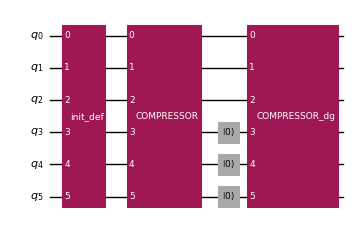

In [14]:
circuit = complete_circuit(compressor, decompressor)
# Draw the circuit diagram.
circuit.draw('mpl', scale=0.5, style="iqp")

### Run the experiment without optimization

0 - Recovered state fidelity = 0.6330509505908257


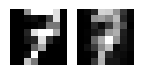

1 - Recovered state fidelity = 0.8360139910006471


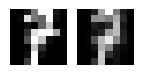

2 - Recovered state fidelity = 0.7672190517677715


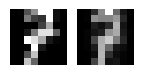

3 - Recovered state fidelity = 0.6250022110882075


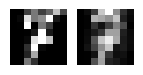

4 - Recovered state fidelity = 0.4953967120784865


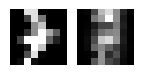

5 - Recovered state fidelity = 0.8200325993044293


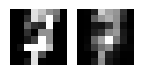

6 - Recovered state fidelity = 0.7861286071951729


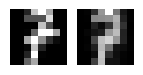

7 - Recovered state fidelity = 0.620826639646834


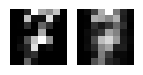

8 - Recovered state fidelity = 0.564786544561403


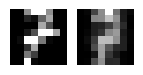

9 - Recovered state fidelity = 0.8125863316583054


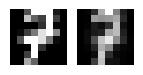

10 - Recovered state fidelity = 0.7822300488157591


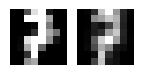

11 - Recovered state fidelity = 0.8419551312411576


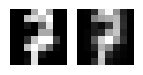

12 - Recovered state fidelity = 0.6486822011985286


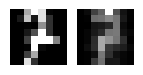

13 - Recovered state fidelity = 0.8754218121158671


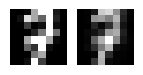

14 - Recovered state fidelity = 0.45822454856807826


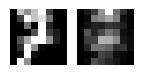

15 - Recovered state fidelity = 0.7070734404077571


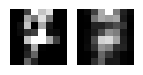

16 - Recovered state fidelity = 0.7463202631544206


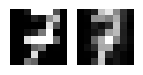

17 - Recovered state fidelity = 0.8127906716050237


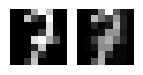

18 - Recovered state fidelity = 0.5227965562691993


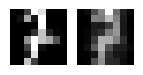

19 - Recovered state fidelity = 0.45278344143973237


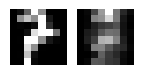

In [15]:
fidelities[0], figures[0] = experiment(
    test_input,
    compressor,
    decompressor,
    verbose=2
)

***
## Experiment with optimization 1
***
This optimization is based on the conservation of entropy.
As we are dealing with a pure state (Alice's side), our goal is to produce an initial state of zero entropy (or close to zero) on Bob's side.

### Constructs the set of gates to initialize the mixed-states.

In [16]:
# Applies the compression process to each of the train samples,
# calculates the correspondent trash state,
# and stores the correspondent mixed state initializer gate.

references_1 = []
for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = StatePreparation(test_sample)

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    trash_state = partial_trace(Statevector(circuit), compressor.latent_qubits)
    references_1.append([
        MixedInitialize(trash_state.data.T, classical=True, reset=True)
    ])

    # e_vals, e_vecs = np.linalg.eigh(trash_state.data)
    # references_1.append([
    #     MixedInitialize(e_vecs.T, probabilities=e_vals, classical=True, reset=True)
    # ])

### Draw an example of the reference state initializer

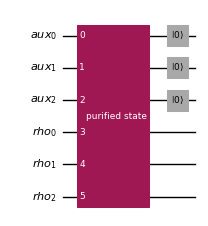

In [17]:
references_1[0][0].definition.draw('mpl', scale=0.5, style="iqp")

### Draws an example of the complete circuit

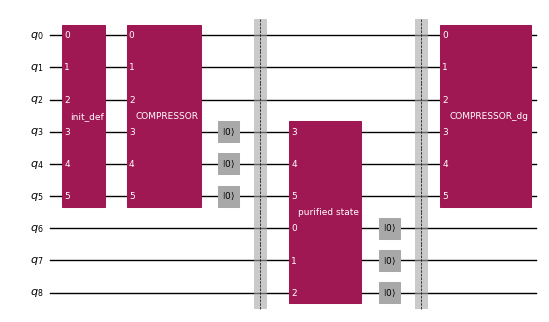

In [18]:
circuit = complete_circuit(compressor, decompressor, references_1)
# Draw an example of the circuit.
circuit.draw('mpl', scale=0.5, style="iqp")

## Optimized experiment:
Uses the exact trash state as the reference state.
This relies on classical communication, as the trash state must be transmited between Alice and Bob for each execution.

In [19]:
fidelities[1], figures[1] = experiment(
    test_input,
    compressor,
    decompressor,
    references=references_1,
    verbose=1
)

0 - Recovered state fidelity = 0.7202845216587613
1 - Recovered state fidelity = 0.8641344533863171
2 - Recovered state fidelity = 0.7840995873155402
3 - Recovered state fidelity = 0.6279248124917903
4 - Recovered state fidelity = 0.49863518217795133
5 - Recovered state fidelity = 0.8586900274252544
6 - Recovered state fidelity = 0.8045748245399826
7 - Recovered state fidelity = 0.6438034286642064
8 - Recovered state fidelity = 0.5816611644046847
9 - Recovered state fidelity = 0.8231655945804978
10 - Recovered state fidelity = 0.7807606249688969
11 - Recovered state fidelity = 0.8627222861855258
12 - Recovered state fidelity = 0.6522208018636663
13 - Recovered state fidelity = 0.8757386348881581
14 - Recovered state fidelity = 0.4350368074716167
15 - Recovered state fidelity = 0.7229535066555434
16 - Recovered state fidelity = 0.7832118112385821
17 - Recovered state fidelity = 0.8238589566562361
18 - Recovered state fidelity = 0.5221956002982223
19 - Recovered state fidelity = 0.436707

***
## Experiment with optimization 2
***
This optimization reduces the cost of the previous one by relying on single-qubit tomography. That way, the cost of the tomography is linear on the number of trash qubits, O(n_t), and the cost of the classical communication is also O(n_t).

### Constructs the set of gates to initialize the mixed-states.

In [20]:
references_2 = []

for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = StatePreparation(test_sample)

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    single_qubit_initializers = []
    for trash_qubit in compressor.trash_qubits:
        trash_qubits = list(set(compressor.trash_qubits) - set([trash_qubit]))
        trash_state = partial_trace(Statevector(circuit), trash_qubits + compressor.latent_qubits)
        
        single_qubit_initializers.append(
            MixedInitialize(trash_state.data.T, classical=True, reset=True)
        )

        # e_vals, e_vecs = np.linalg.eigh(trash_state.data)
        # single_qubit_initializers.append(
        #     MixedInitialize(e_vecs.T, probabilities=e_vals, classical=True, reset=True)
        # )

    references_2.append(single_qubit_initializers)

### Draw an example of the reference state initializer

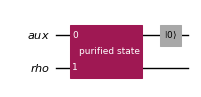

In [21]:
references_2[0][0].definition.draw('mpl', scale=0.5, style="iqp")

### Draw an example of the complete circuit

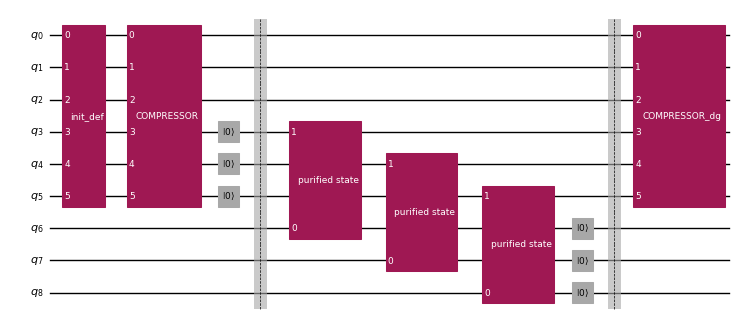

In [22]:
circuit = complete_circuit(compressor, decompressor, references_2)
# Draw an example of the circuit.
circuit.draw('mpl', scale=0.5, style="iqp")

## Optimized experiment:
Uses the single-qubit trash states as the reference state.
This relies on classical communication, as the trash state must be transmited between Alice and Bob for each execution, but the cost is only O(n_t).

In [23]:
fidelities[2], figures[2] = experiment(
    test_input,
    compressor,
    decompressor,
    references=references_2,
    verbose=1
)

0 - Recovered state fidelity = 0.6438323406083223
1 - Recovered state fidelity = 0.8348357876373533
2 - Recovered state fidelity = 0.7594813235354523
3 - Recovered state fidelity = 0.5852059960044472
4 - Recovered state fidelity = 0.43296608340526116
5 - Recovered state fidelity = 0.8227609801553457
6 - Recovered state fidelity = 0.7753497518526175
7 - Recovered state fidelity = 0.566649768667657
8 - Recovered state fidelity = 0.5155903984584601
9 - Recovered state fidelity = 0.8093523879949418
10 - Recovered state fidelity = 0.7710186963657284
11 - Recovered state fidelity = 0.8351239937053972
12 - Recovered state fidelity = 0.6140835127460569
13 - Recovered state fidelity = 0.8721904091853926
14 - Recovered state fidelity = 0.36770761624615544
15 - Recovered state fidelity = 0.6940374479444279
16 - Recovered state fidelity = 0.7404464836941239
17 - Recovered state fidelity = 0.8089084111858292
18 - Recovered state fidelity = 0.47116149605312435
19 - Recovered state fidelity = 0.37746

***
## Summary
***

In [24]:
zip_fidelities = list(zip(fidelities[0],fidelities[1],fidelities[2]))
for i, (item1, item2, item3) in enumerate(zip_fidelities):
    print(i, '-', item1, item2, item3)

print('\navg', *np.average(zip_fidelities, axis=0))
print('min', *np.min(zip_fidelities, axis=0))
print('max', *np.max(zip_fidelities, axis=0))
print('std', *np.std(zip_fidelities, axis=0))

0 - 0.6330509505908257 0.7202845216587613 0.6438323406083223
1 - 0.8360139910006471 0.8641344533863171 0.8348357876373533
2 - 0.7672190517677715 0.7840995873155402 0.7594813235354523
3 - 0.6250022110882075 0.6279248124917903 0.5852059960044472
4 - 0.4953967120784865 0.49863518217795133 0.43296608340526116
5 - 0.8200325993044293 0.8586900274252544 0.8227609801553457
6 - 0.7861286071951729 0.8045748245399826 0.7753497518526175
7 - 0.620826639646834 0.6438034286642064 0.566649768667657
8 - 0.564786544561403 0.5816611644046847 0.5155903984584601
9 - 0.8125863316583054 0.8231655945804978 0.8093523879949418
10 - 0.7822300488157591 0.7807606249688969 0.7710186963657284
11 - 0.8419551312411576 0.8627222861855258 0.8351239937053972
12 - 0.6486822011985286 0.6522208018636663 0.6140835127460569
13 - 0.8754218121158671 0.8757386348881581 0.8721904091853926
14 - 0.45822454856807826 0.4350368074716167 0.36770761624615544
15 - 0.7070734404077571 0.7229535066555434 0.6940374479444279
16 - 0.7463202631

0


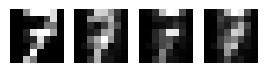

1


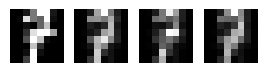

2


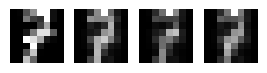

3


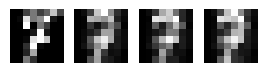

4


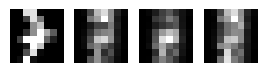

5


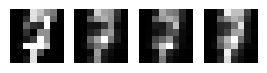

6


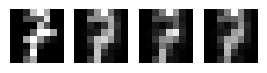

7


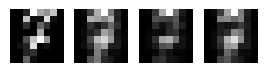

8


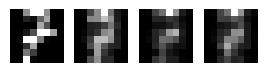

9


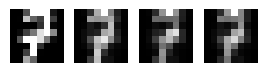

10


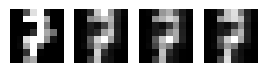

11


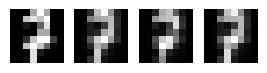

12


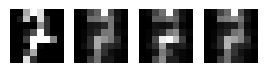

13


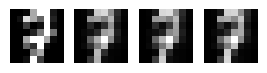

14


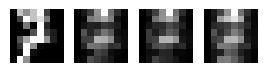

15


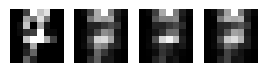

16


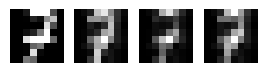

17


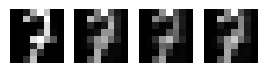

18


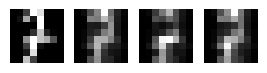

19


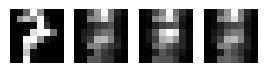

In [25]:
for i, (item1, item2, item3) in enumerate(zip(figures[0],figures[1],figures[2])):
    print(i)
    plot_digits([item1[0], item1[1], item2[1], item3[1]], n_qubits)